In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-03 13:50:33,779 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        data.append(row)
    return pd.DataFrame(data)

In [3]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model, adjust_bias), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
        y_test = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_pred']], index=data.index)
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
        y_test['compactness'] = np.minimum(1, np.maximum(0, 1.0 / (y_test['compactness'] / (4 * np.pi))))
        y_pred['compactness'] = np.minimum(1, np.maximum(0, 1.0 / (y_pred['compactness'] / (4 * np.pi))))
        
        idx = np.isclose(y_pred['compactness'], 1)
        y_pred['orientation'][idx] = 0
        y_pred['eccentricity'][idx] = 0
        idx = np.isclose(y_test['compactness'], 1)
        y_test['orientation'][idx] = 0
        y_test['eccentricity'][idx] = 0
            
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'adjust_bias': adjust_bias,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [4]:
results_dir = '../../results/shape7cv/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 182 files


In [5]:
subjects = ['TB', '12-005', '51-009', '52-001']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [6]:
data = load_data(pickle_files, verbose=False)

In [7]:
data.columns

Index(['adjust_bias', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [8]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity', 'compactness']
r2cols = ['r2_%s' % name for name in predcols]

In [9]:
data.groupby(groupcols + ['idx_fold'], sort=False)['exetime', 'best_train_cost'].agg(['mean', 'std', 'count'])

exetime                      \
                                            mean           std count   
subject model adjust_bias idx_fold                                     
12-005  C     False       0          2120.356020    435.586233     5   
                          1          4684.022018   5692.821913     5   
                          10         1855.584668    379.630182     3   
                          11         1513.161855    727.420760     3   
                          12         1475.122099    573.977286     3   
                          13         2542.664073    421.780127     3   
                          14         1299.399342    773.073590     3   
                          15         1814.808060    762.574941     3   
                          16         1615.493856    367.248977     3   
                          2          1549.953614    735.772509     5   
                          3          2613.648953   2283.082580     5   
                          4          1494.354944    426.532979     3   
                          5          2591.737461   1198.626229     3   
                          6          1698.421810    662.070702     3   
                          7          2063.615876   1227.731850     3   
                          8          1985.993823   1422.899398     3   
                          9         10334.310448   7678.389615     3   
51-009  C     False       0          4695.855042    904.091505     3   
                          1         13829.578892    498.458208     3   
                          10         9533.024771   4323.693411     3   
                          11         9902.282642   6771.839465     3   
                          12         7390.029801   1230.207779     3   
                          13         6539.770910    288.820477     3   
                          2          9448.282982   3539.434836     3   
                          3          8968.452139   4654.674232     3   
                          4          6833.972360   3944.706680     3   
                          5          8577.233146   4478.998114     3   
                          6         14419.178628   1028.020902     3   
                          7          9133.986763   4596.677975     3   
                          8         13220.122674   2120.754899     3   
                          9          8083.871955   4768.756860     3   
52-001  C     False       0          7210.196234  11338.799749     3   
                          1          7189.541716   8889.341065     3   
                          10         7760.397235  10028.234731     3   
                          11        13477.714645  10568.465669     3   
                          12        12541.309748  10336.757873     3   
                          13         7751.448899   9758.117511     3   
                          14        11863.154206   9941.685365     3   
                          15         7472.360692  10493.983178     3   
                          16        14612.163672  11788.215514     3   
                          17         8232.966737   8561.450482     3   
                          18         8230.313970  10222.632319     3   
                          2         12570.996903   9158.410496     3   
                          3          7844.729091  10218.822462     3   
                          4          7014.134738  10368.820906     3   
                          5          6919.981167  10406.241260     3   
                          6          8242.012253   9978.998311     3   
                          7          7335.433516   9574.156176     3   
                          8          2908.872074   1573.286956     3   
                          9          7326.857215  10419.415709     3   
TB      C     False       0          2429.028989   1529.608105     3   
                          1           993.197765    396.534831     3   
                          2          1205.513948    198.420808     3   
         

# The best runs in their respective category

In [10]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])['best_train_cost'].agg(['count',
                                                                                                        'min'])

Best scores:


count         min
subject model adjust_bias idx_fold                   
12-005  C     False       0             1    5.682978
                          1             1    5.142043
                          2             1    5.586852
                          3             1    5.565589
                          4             1    6.749199
                          5             1    5.688052
                          6             1    5.993486
                          7             1    5.497064
                          8             1    5.153983
                          9             1    7.354783
                          10            1    5.661255
                          11            1    6.567506
                          12            1    6.058233
                          13            1    5.437714
                          14            1    5.834651
                          15            1    5.590268
                          16            1    6.230559
51-009  C     False       0             1   22.359323
                          1             1   11.326310
                          2             1   41.641162
                          3             1   97.892370
                          4             1   20.873106
                          5             1   25.254875
                          6             1   47.508552
                          7             1   79.676091
                          8             1   57.978723
                          9             1   49.654623
                          10            1  129.120954
                          11            1   44.739712
                          12            1  156.957880
                          13            1  123.055319
52-001  C     False       0             1    3.731953
                          1             1    3.672762
                          2             1    3.852544
                          3             1    3.347353
                          4             1    3.656563
                          5             1    3.777300
                          6             1    3.814009
                          7             1    3.713765
                          8             1    3.246996
                          9             1    3.591668
                          10            1    4.056979
                          11            1    3.812447
                          12            1    3.534962
                          13            1    3.776940
                          14            1    3.989082
                          15            1    3.993147
                          16            1    3.901118
                          17            1    3.910826
                          18            1    3.952457
TB      C     False       0             1    6.163238
                          1             1    5.476951
                          2             1    5.473662
                          3             1    5.463689
                          4             1    4.893863
                          5             1    5.268905
                          6             1    5.652152
                          7             1    5.974360

In [11]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,adjust_bias,best_test_cost,model,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,False,6.554768,C,-1.440206,-0.752440,-0.799727,0.437605,12-005,area compactness eccentricity orienta...,area compactness eccentricity orienta...
1,False,5134.834523,C,-2.810998,-13.831146,-5112.913334,-1.279045,51-009,area compactness eccentricity orient...,area compactness eccentricity orient...
2,False,5.803091,C,-1.028353,-1.119875,-0.030945,0.376082,52-001,area compactness eccentricity orien...,area compactness eccentricity orien...
3,False,6.749276,C,-1.305476,-0.714869,-1.429598,0.700666,TB,area compactness eccentricity orienta...,area compactness eccentricity orient...


# Plot predictions

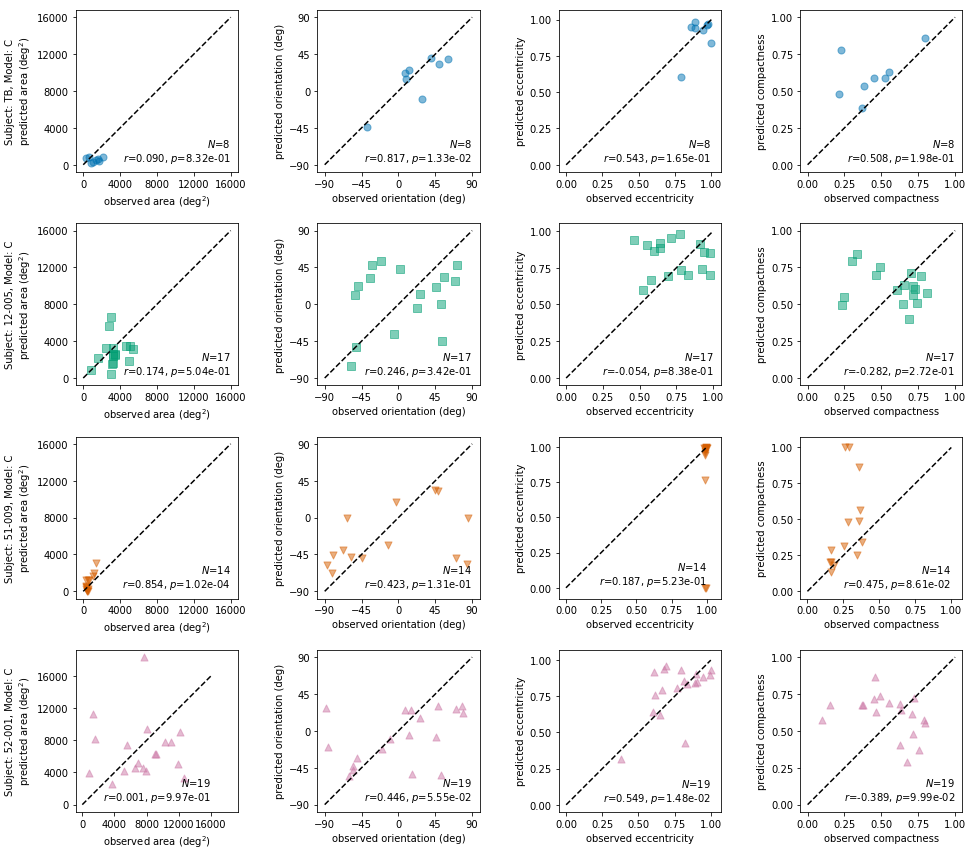

In [12]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 16000], [-90, 90], [0, 1], [0, 1]]
limits = [[-1600, 16600], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d\n$r$=%.3f, $p$=%.2e" % (len(y), rval, pval), va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (row['subject'], row['model'], labels[0]))
fig.tight_layout()
fig.savefig('predict-cv-%s.png' % plotmodel)